In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
pd.set_option('display.max_rows', 100)

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/google-play-store-apps/googleplaystore.csv
/kaggle/input/google-play-store-apps/license.txt
/kaggle/input/google-play-store-apps/googleplaystore_user_reviews.csv


In [2]:
data = pd.read_csv("../input/google-play-store-apps/googleplaystore.csv")
data.shape

(10841, 13)

In [3]:
print(f"Number of unique apps:{data['App'].nunique()}")

Number of unique apps:9660


In [4]:
# Since the number of unique apps < Total number of data points, then there must be some duplicate apps.
# I am going to consider Apps with same name and category as the duplicate apps. Let's find out the duplicate apps.

# So there are around 750 apps with the same name and category. So in the next step I am going to remove those
# apps.
data[data.duplicated(subset=["App", "Category"])]["App"].nunique()

748

In [5]:
# Removing the Duplicates
print(f"Before removing the duplicates, shape of data: {data.shape}")
data= data.drop_duplicates(subset=["App", "Category"], keep='last')
data.reset_index(drop=True, inplace=True)
print(f"After removing the duplicates, shape of data: {data.shape}")

Before removing the duplicates, shape of data: (10841, 13)
After removing the duplicates, shape of data: (9745, 13)


In [6]:
# Let's check the different categories of apps
data["Category"].unique()

array(['ART_AND_DESIGN', 'AUTO_AND_VEHICLES', 'BEAUTY',
       'BOOKS_AND_REFERENCE', 'BUSINESS', 'COMICS', 'COMMUNICATION',
       'DATING', 'EDUCATION', 'ENTERTAINMENT', 'EVENTS', 'FINANCE',
       'FOOD_AND_DRINK', 'HEALTH_AND_FITNESS', 'HOUSE_AND_HOME',
       'LIBRARIES_AND_DEMO', 'LIFESTYLE', 'GAME', 'FAMILY', 'MEDICAL',
       'SOCIAL', 'SHOPPING', 'PHOTOGRAPHY', 'SPORTS', 'TRAVEL_AND_LOCAL',
       'TOOLS', 'PERSONALIZATION', 'PRODUCTIVITY', 'PARENTING', 'WEATHER',
       'VIDEO_PLAYERS', 'NEWS_AND_MAGAZINES', 'MAPS_AND_NAVIGATION',
       '1.9'], dtype=object)

In [7]:
# One app has category 1.9 which doesn't make sense.
data[data["Category"] == '1.9']

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
9376,Life Made WI-Fi Touchscreen Photo Frame,1.9,19.0,3.0M,"1,000+",Free,0,Everyone,NaN,"February 11, 2018",1.0.19,4.0 and up,NaN


In [8]:
# It looked like the values are shifted backwards from the Rating column. For now removing the row.
data = data.drop(data[data["Category"] == "1.9"].index)
print(data.shape)

(9744, 13)


In [9]:
# Missing values in different columns
data.isnull().sum()

App                  0
Category             0
Rating            1464
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       0
Genres               0
Last Updated         0
Current Ver          8
Android Ver          2
dtype: int64

In [10]:
# Data Cleaning
# Reference: https://www.kaggle.com/sabasiddiqi/google-play-store-apps-data-cleaning
"""
Size Column
-----------
Size column contains size of the applications - with kb or mb attached to it. So we are going to replace it with
their actual size k - 'e+3', M - 'e+6'. For now we are going to replace the "varies with device part" with NaN 
values which we can fill with the median size for that category.
"""
data["Size"] = data["Size"].str.replace('k', 'e+3')
data["Size"] = data["Size"].str.replace('M', 'e+6')
data["Size"].replace("Varies with device", np.nan, inplace=True)

data["Size"] = pd.to_numeric(data["Size"])

In [11]:
# Let's impute the varies with device value in the column Size with the median value of the "Size" for that 
# particular category of apps
def impute_median(s):
    return s.fillna(s.median())

by_category = data.groupby(["Category"])
data["Size"] = by_category["Size"].transform(impute_median)

In [12]:
"""
Rating Column
-------------
Since rating column contains a lot of missing values, I am going to the fill those with the median Rating
for the apps of the same group as I have done for the Size column.
"""
data["Rating"] = by_category["Rating"].transform(impute_median)

In [13]:
"""
Installs Column
---------------
The Installs column is of type String. But it should be a numeric column as it shows the number of installs.
For that I am going to remove the '+' and ',' from the Installs column.
"""
data["Installs"] = pd.to_numeric(data["Installs"].str.strip("+").str.replace(",", ""))

In [14]:
# As we know the apps with 0 installs should not have any ratings ;) but in this approach we are going to rate
# those apps also which is incorrect. So I am going to modify their ratings to 0 which seems logical & 
# fortunately we don't have any App with negative review.
data.loc[data["Installs"] == 0, ["Rating"]] = 0

In [15]:
"""
Type Column
-----------
Let's checkout the type column which is a categorical column. It has only one missing value. Let's check for which
app we have missing values. 

"Price" of the app for which the "Type" column is missing is 0. Since this is only a single value missing, I am 
going to directly impute it as of "Type" = "Free".
"""
# print(data[data["Type"].isnull()])
data.at[8052, "Type"] = "Free"

In [16]:
"""
Price Column
------------
Price column do not have any missing values. But the prices are present in strings. So first let's remove those and 
then convert it to a numeric column.
"""
data["Price"] = pd.to_numeric(data["Price"].str.strip("$"))

In [17]:
"""
Reviews Column
--------------
Reviews column contains number in string format. So need to convert that to numeric format.
"""
data["Reviews"] = pd.to_numeric(data["Reviews"])

In [18]:
"""
Genres Column
-------------
Since in the "Genres" column some data is present in the a;b format. 
So spliting this columns to 2 different column.
"""
data["Subgenres"] = data["Genres"].apply(lambda x: x.split(';')[-1])
data["Genres"] = data["Genres"].apply(lambda x: x.split(';')[0])
data.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Subgenres
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19000000.0,10000,Free,0.0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up,Art & Design
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14000000.0,500000,Free,0.0,Everyone,Art & Design,"January 15, 2018",2.0.0,4.0.3 and up,Pretend Play
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8700000.0,5000000,Free,0.0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up,Art & Design
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25000000.0,50000000,Free,0.0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up,Art & Design
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2800000.0,100000,Free,0.0,Everyone,Art & Design,"June 20, 2018",1.1,4.4 and up,Creativity


In [19]:
"""
Last Updated Column
-------------------
Convert the last updated column to datetime column. Create a new column which indicates the difference between the
last updated column and current date.
"""
data["Last Updated"] = pd.to_datetime(data["Last Updated"])
data["Updategaps"] = pd.to_datetime(datetime.today().strftime("%m-%d-%Y")) - data["Last Updated"]
data.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Subgenres,Updategaps
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19000000.0,10000,Free,0.0,Everyone,Art & Design,2018-01-07,1.0.0,4.0.3 and up,Art & Design,759 days
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14000000.0,500000,Free,0.0,Everyone,Art & Design,2018-01-15,2.0.0,4.0.3 and up,Pretend Play,751 days
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8700000.0,5000000,Free,0.0,Everyone,Art & Design,2018-08-01,1.2.4,4.0.3 and up,Art & Design,553 days
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25000000.0,50000000,Free,0.0,Teen,Art & Design,2018-06-08,Varies with device,4.2 and up,Art & Design,607 days
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2800000.0,100000,Free,0.0,Everyone,Art & Design,2018-06-20,1.1,4.4 and up,Creativity,595 days


In [20]:
data["Updategaps"] = pd.to_numeric(data["Updategaps"].astype(str).str[:3])

In [21]:
# Removing the "Current Ver", Android Ver", "Last Updated" columns
data.drop(columns=["Current Ver", "Android Ver", "Last Updated"], inplace=True)

In [22]:
def return_plot(figsize=(16, 8), nrows=1, ncols=1):
    fig, ax = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols)
    return fig, ax

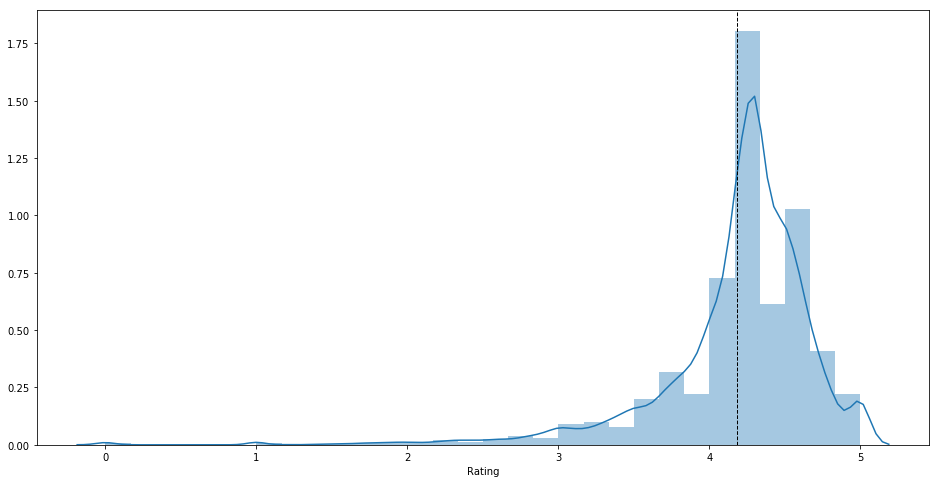

In [23]:
# Let's checkout the Ratings distribution. 
# From the ratings distribution it is clear that most of the apps have rating more than 4. 
fig, ax = return_plot()
sns.distplot(data["Rating"], bins=30, ax=ax)
ax.axvline(data["Rating"].mean(), color="k", linestyle="dashed", linewidth=1)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),
 <a list of 33 Text xticklabel objects>)

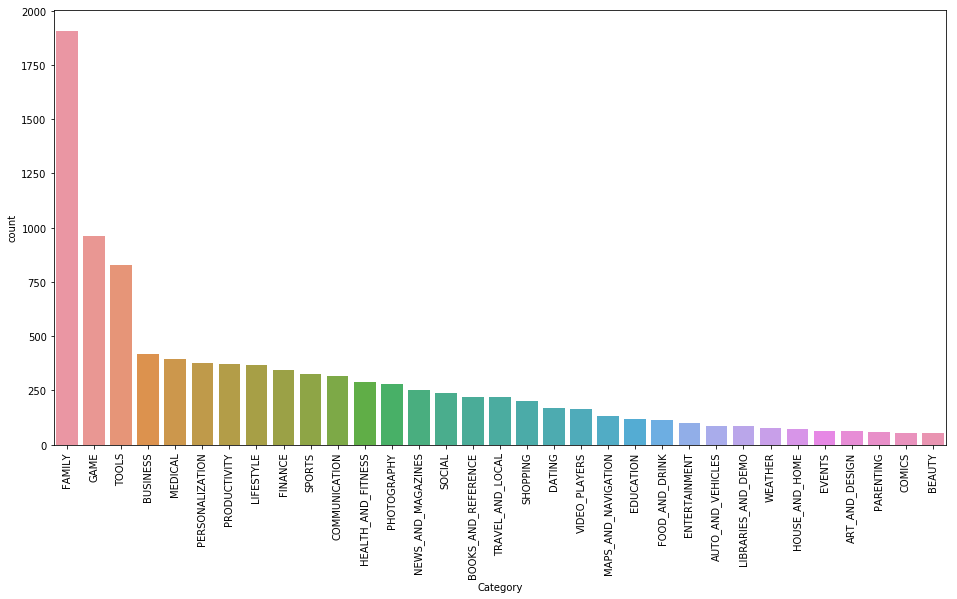

In [24]:
# Let's check the categories column.
fig, ax = return_plot()
sns.countplot(x="Category", data=data, order=data["Category"].value_counts().index, ax=ax)
plt.xticks(rotation=90)

(array([0, 1]), <a list of 2 Text xticklabel objects>)

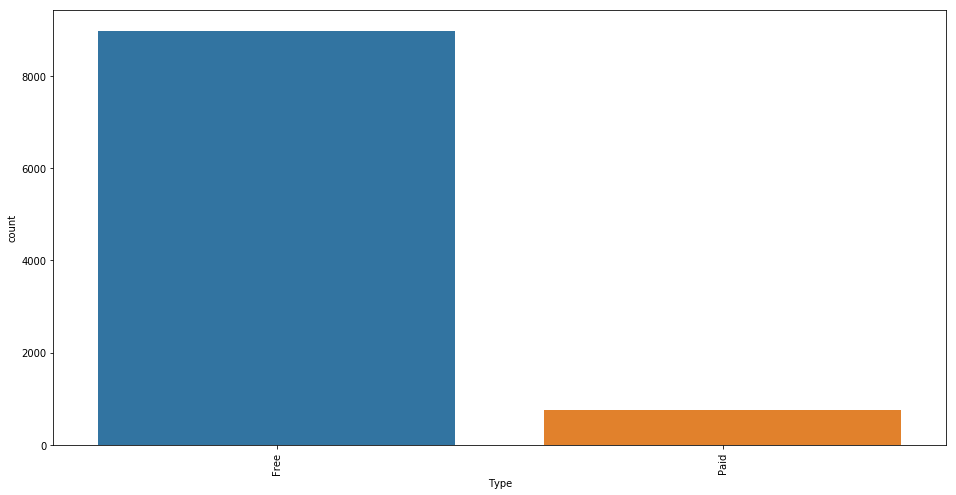

In [25]:
# Let's look at the type of Apps (Free or paid)
# There are a lot of free apps than paid apps. So can we consider "Free apps" are more popular than "Paid apps" ?
fig, ax = return_plot()
sns.countplot(x="Type", data=data, order=data["Type"].value_counts().index, ax=ax)
plt.xticks(rotation=90)

In [26]:
# Let's drill down the paid apps
paid_apps = data[data["Type"] == "Paid"]
free_apps = data[data["Type"] == "Free"]

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 30 Text xticklabel objects>)

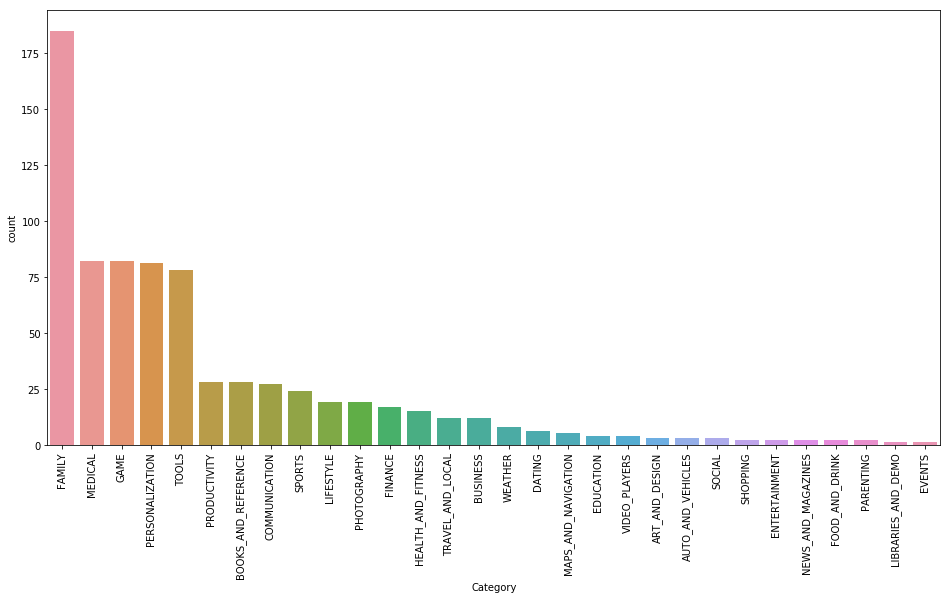

In [27]:
fig, ax = return_plot()
sns.countplot(x="Category", data=paid_apps, order=paid_apps["Category"].value_counts().index, ax=ax)
plt.xticks(rotation=90)

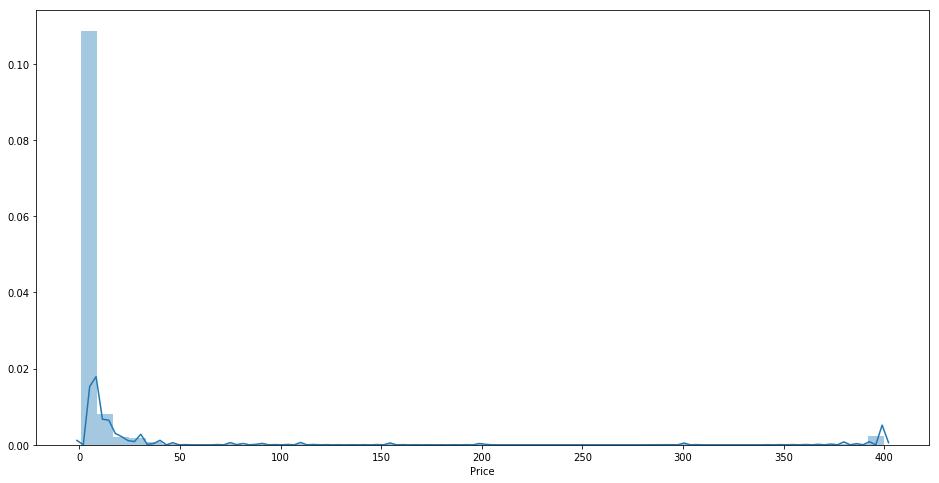

In [28]:
# Price distribution of the paid apps
fig, ax = return_plot()
sns.distplot(paid_apps["Price"], bins=50, ax=ax)

In [29]:
# Let's check the apps whose price > 300$
paid_apps[paid_apps["Price"] > 300]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Subgenres,Updategaps
3101,most expensive app (H),FAMILY,4.3,6,1500000.0,100,Paid,399.99,Everyone,Entertainment,Entertainment,569
3266,💎 I'm rich,LIFESTYLE,3.8,718,26000000.0,10000,Paid,399.99,Everyone,Lifestyle,Lifestyle,696
3271,I'm Rich - Trump Edition,LIFESTYLE,3.6,275,7300000.0,10000,Paid,400.00,Everyone,Lifestyle,Lifestyle,643
4255,I am rich,LIFESTYLE,3.8,3547,1800000.0,100000,Paid,399.99,Everyone,Lifestyle,Lifestyle,754
4258,I am Rich Plus,FAMILY,4.0,856,8700000.0,10000,Paid,399.99,Everyone,Entertainment,Entertainment,627
4260,I Am Rich Premium,FINANCE,4.1,1867,4700000.0,50000,Paid,399.99,Everyone,Finance,Finance,815
4261,I am extremely Rich,LIFESTYLE,2.9,41,2900000.0,1000,Paid,379.99,Everyone,Lifestyle,Lifestyle,584
4262,I am Rich!,FINANCE,3.8,93,22000000.0,1000,Paid,399.99,Everyone,Finance,Finance,786
4263,I am rich(premium),FINANCE,3.5,472,965000.0,5000,Paid,399.99,Everyone,Finance,Finance,101
4266,I Am Rich Pro,FAMILY,4.4,201,2700000.0,5000,Paid,399.99,Everyone,Entertainment,Entertainment,981


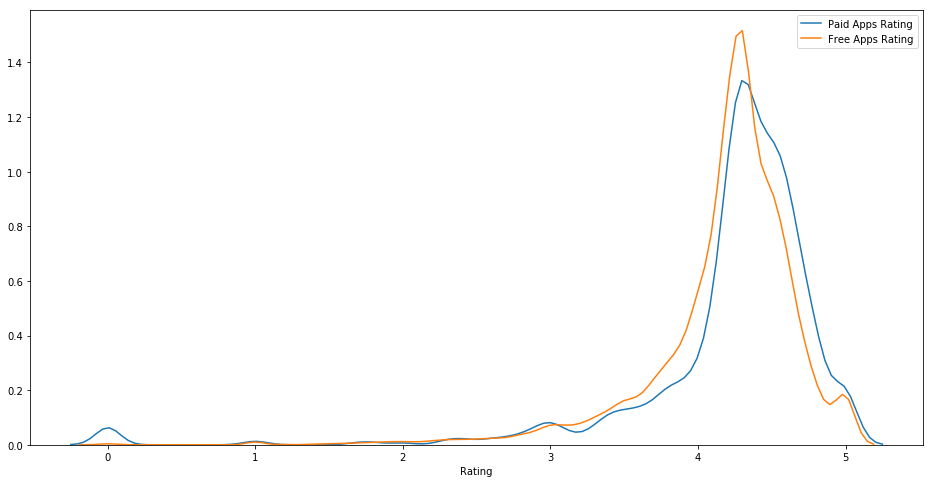

In [30]:
fig, ax = return_plot()
sns.distplot(paid_apps["Rating"], hist=False, ax=ax, label="Paid Apps Rating")
sns.distplot(free_apps["Rating"], hist=False, ax=ax, label="Free Apps Rating")
plt.legend()

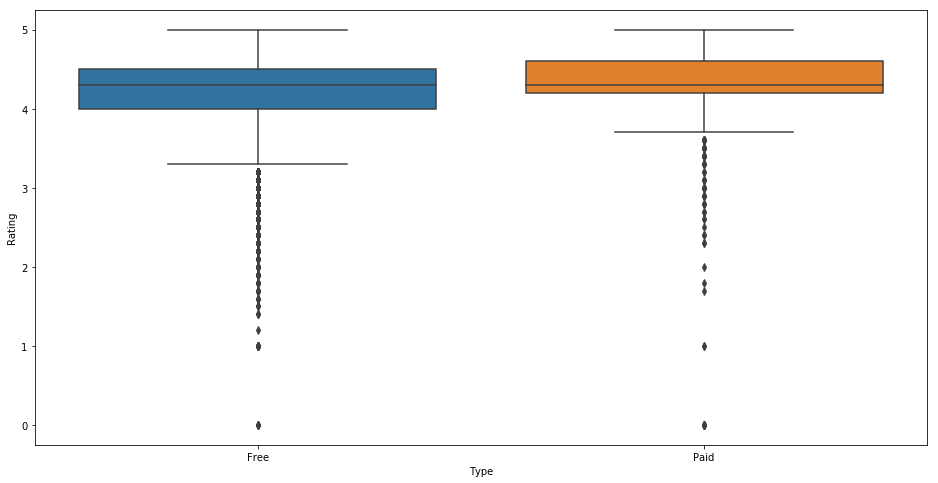

In [31]:
# Rating variation with "Type" of app
fig, ax = return_plot()
sns.boxplot(x="Type", y="Rating", data=data, ax=ax)

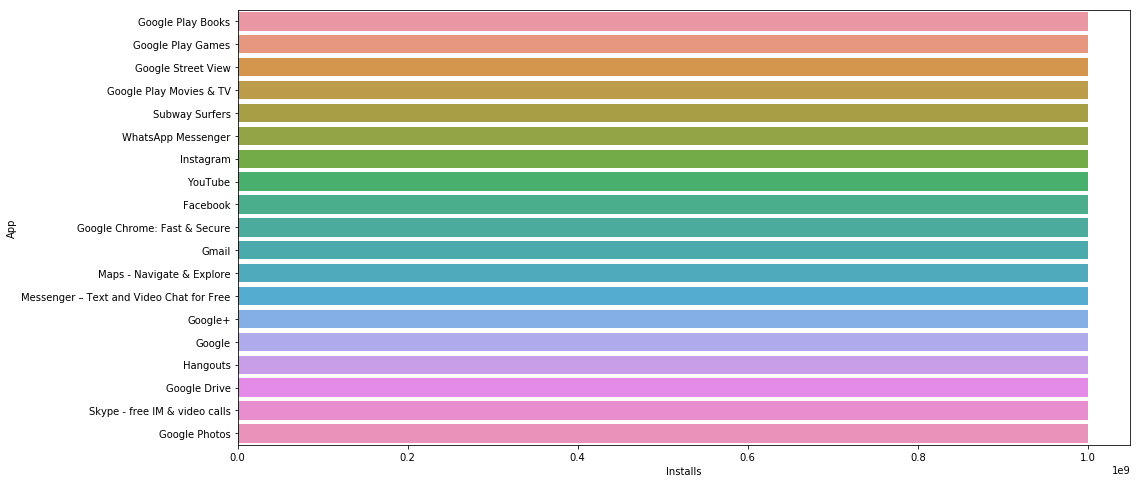

In [32]:
# Let's check the top 20 apps (Depending on the number of installs)
top_20_installed_apps = data.nlargest(20, "Installs")
fig, ax = return_plot()
sns.barplot(x="Installs", y="App", data=top_20_installed_apps)

# Popular apps all have more than 10e9 installs and I can't differentiate it because originally it was present in "10000+" format, but I have truncated the '+' and considered it as 10000.
# Most of the apps in this list are preconfigured in the android phones. 

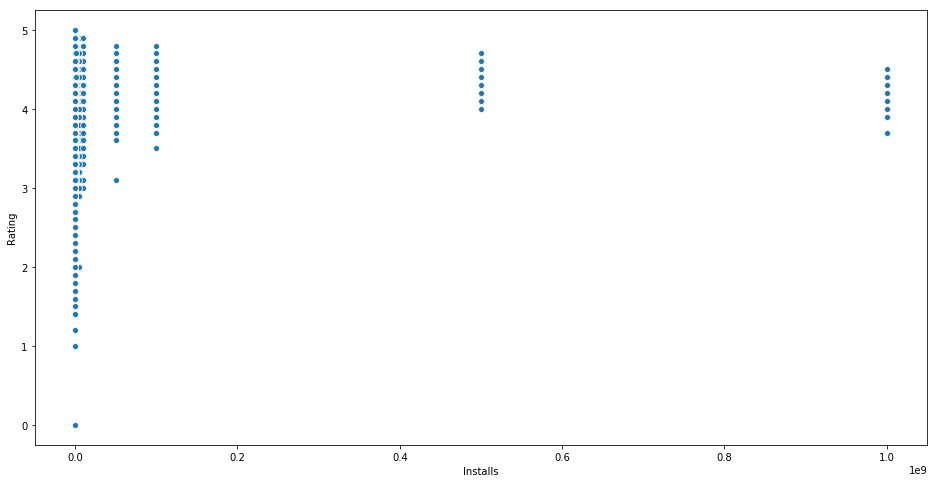

In [33]:
# Let's check the relationship between the number of installs and rating
fig, ax = return_plot()
sns.scatterplot(x="Installs", y="Rating", data=data, ax=ax)

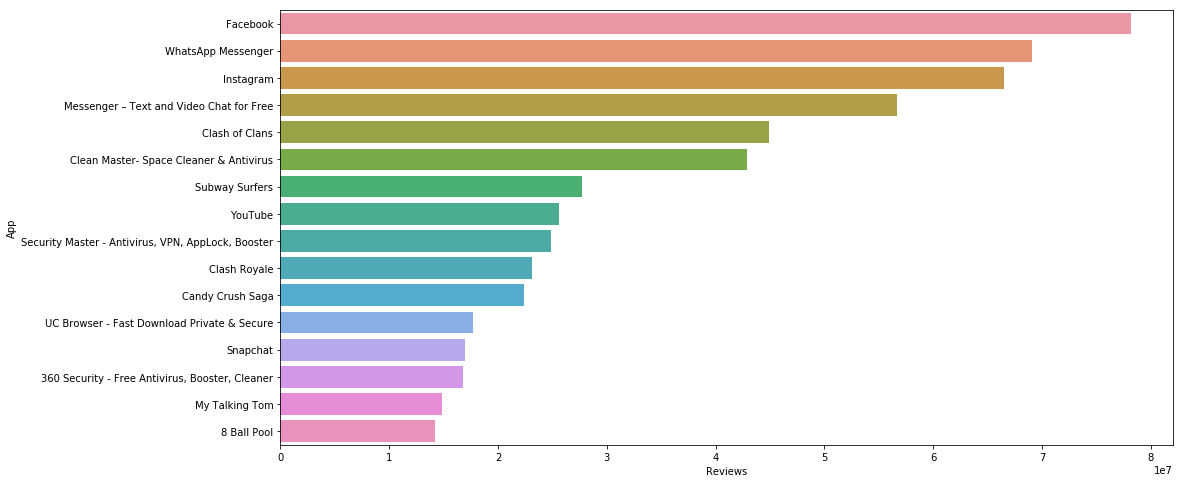

In [34]:
# Top 20 apps depending on the number of reviews
top_20_reviewed_apps = data.nlargest(20, "Reviews")
fig, ax = return_plot()
sns.barplot(x="Reviews", y="App", data=top_20_reviewed_apps)

# Facebook is the most reviewed app in the PlayStore. If we look at the top-3 apps, all of them are from facebook.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),
 <a list of 33 Text xticklabel objects>)

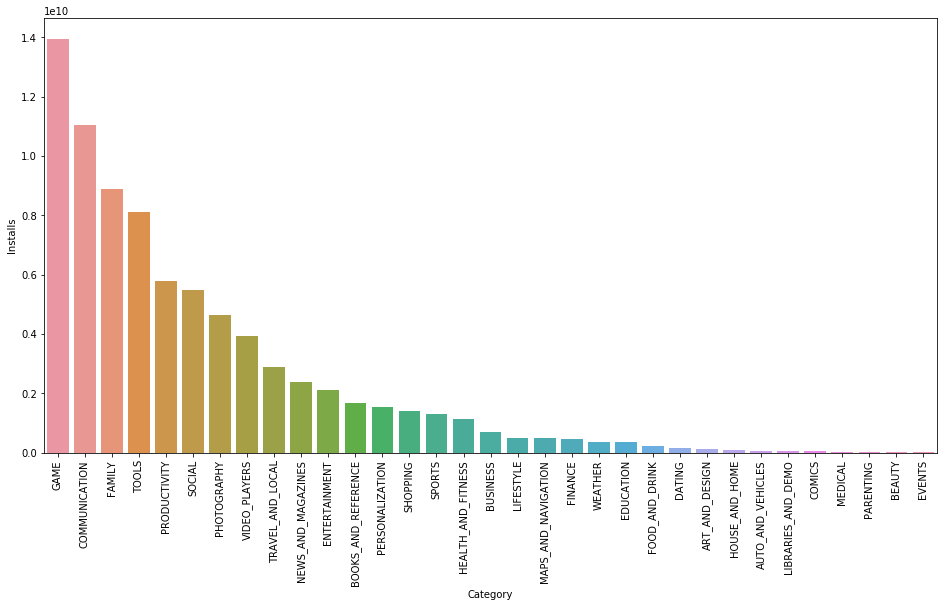

In [35]:
# Most popular category with the largest number of installs
# From the plot below, we can find that "Game" category is the most popular category 
category_installs = data.groupby("Category")[["Installs"]].sum().sort_values(by="Installs", ascending=False).reset_index()
fig, ax = return_plot()
sns.barplot(x="Category", y="Installs", data=category_installs, ax=ax)
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),
 <a list of 33 Text xticklabel objects>)

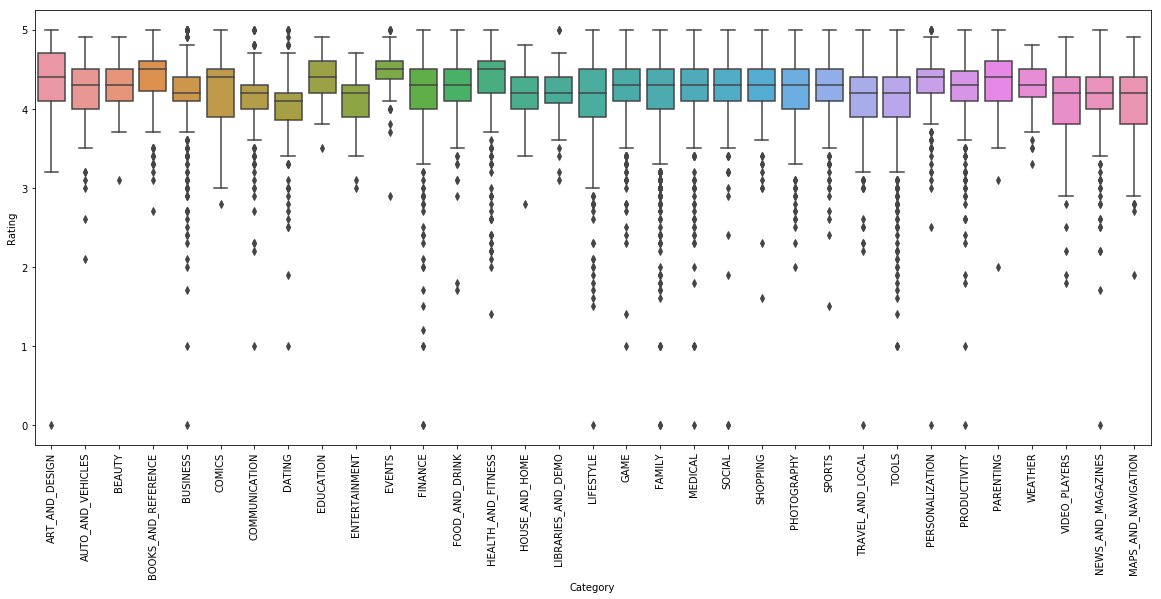

In [36]:
# Variation of rating with category
fig, ax = return_plot(figsize=(20,8))
sns.boxplot(x="Category", y="Rating", data=data, ax=ax)
plt.xticks(rotation=90)

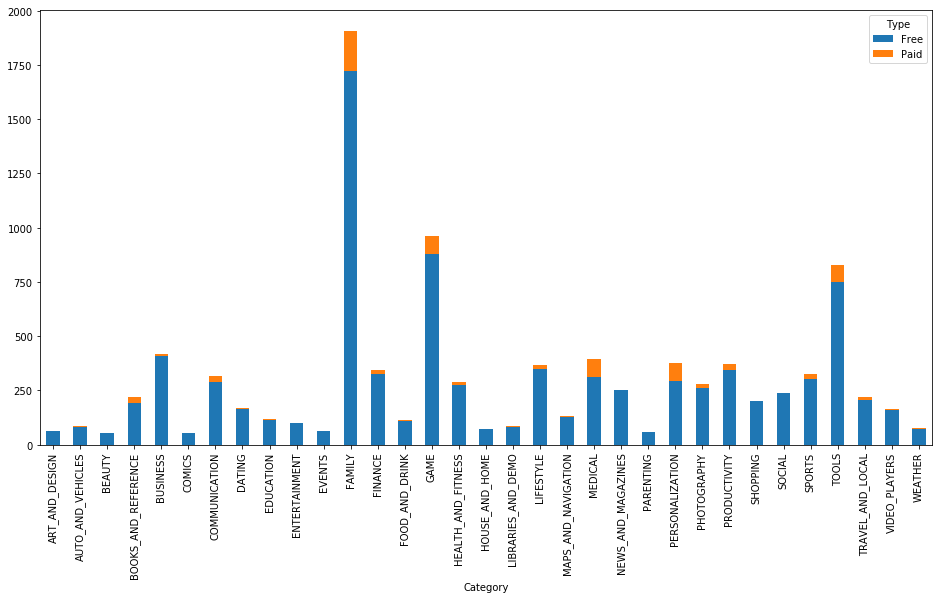

In [37]:
# Free apps and paid apps in each catgory
fig, ax = return_plot()
data.groupby(["Category", "Type"])["App"].count().unstack().fillna(0).plot(kind="bar", stacked=True, ax=ax)
# From the plot, it looks like category "Family" consists most number of "Free" as well as "Paid" apps.

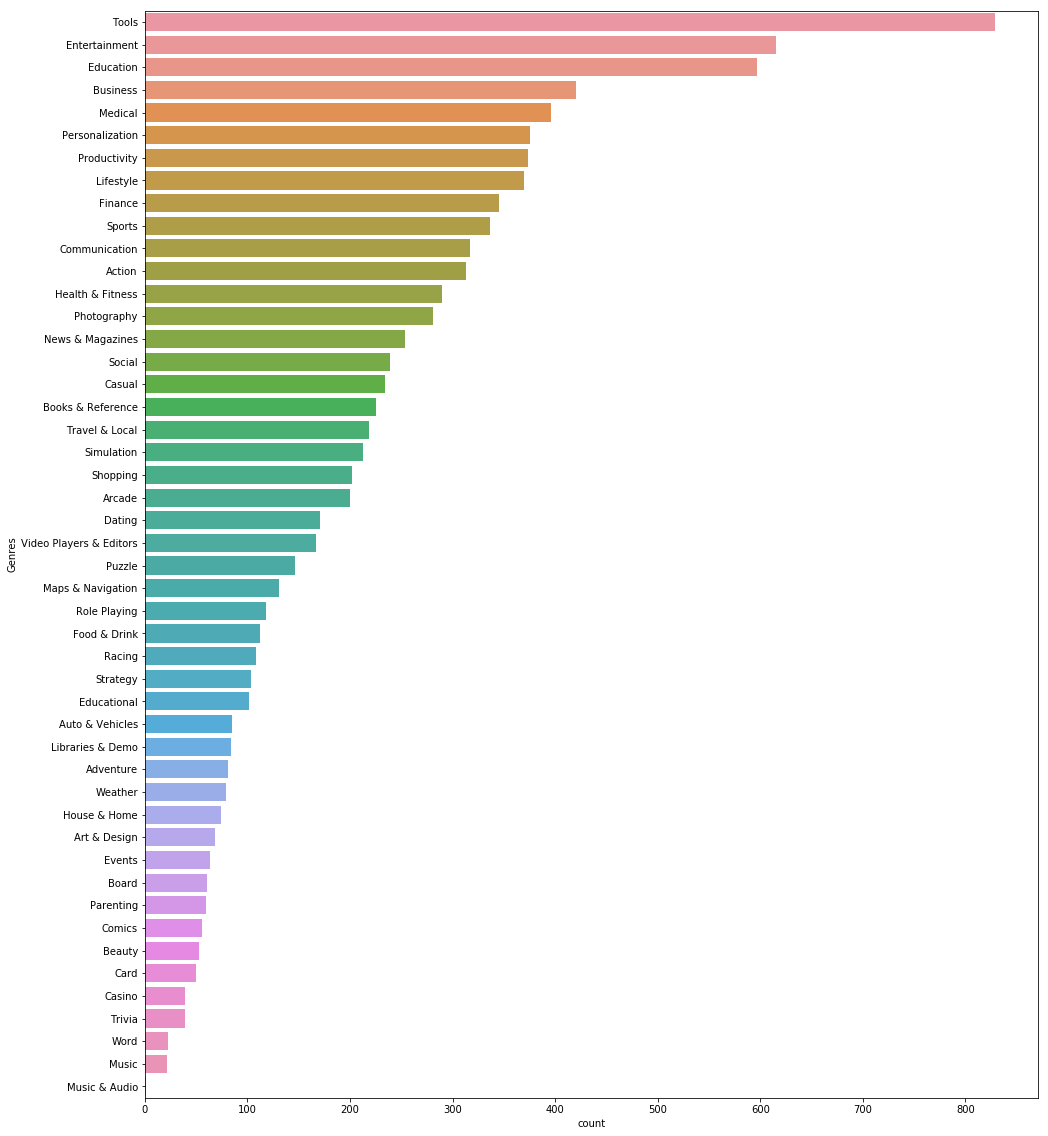

In [38]:
# Different Genres
fig, ax = return_plot(figsize=(16, 20))
sns.countplot(y="Genres", data=data, order=data["Genres"].value_counts().index, ax=ax)

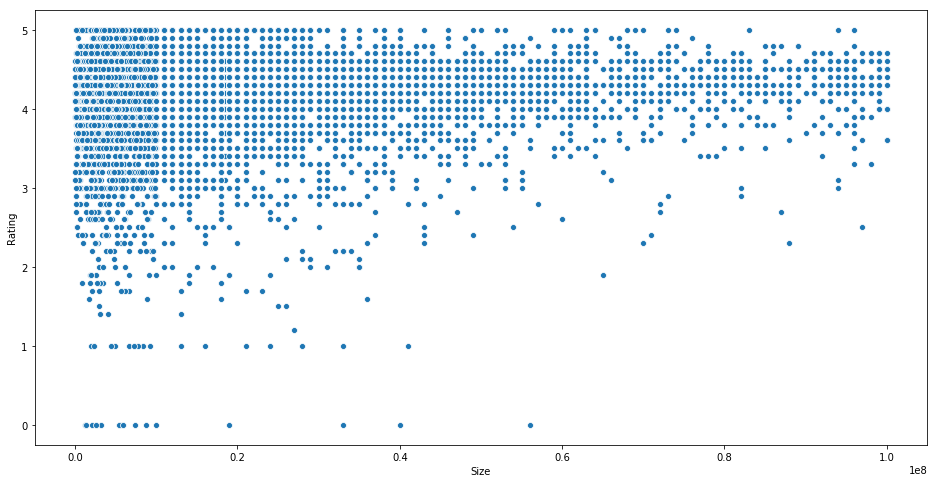

In [39]:
# How the rating varies with the size of the app
fig, ax = return_plot()
sns.scatterplot(x="Size", y="Rating", data=data, ax=ax)

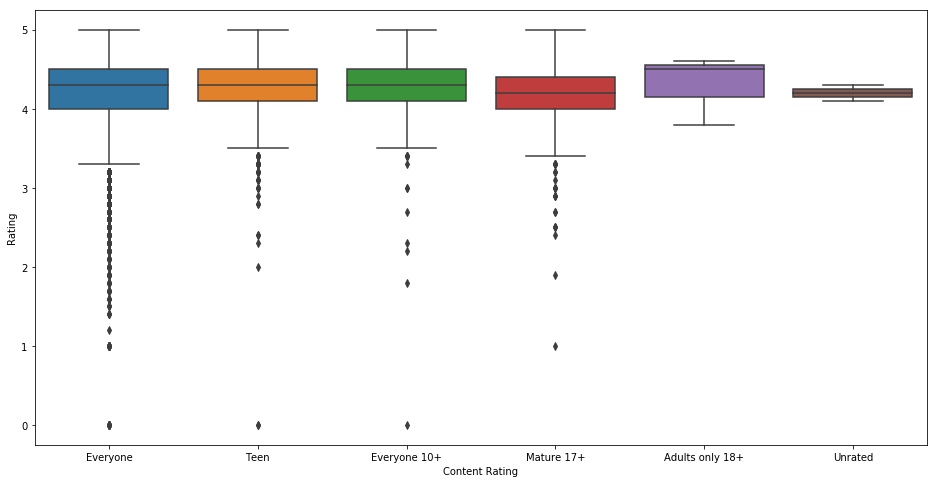

In [40]:
fig, ax = return_plot()
sns.boxplot(x="Content Rating", y="Rating", data=data, ax=ax)

In [41]:
# Let's make a copy of the data for model fitting and drop the App name column from the model_data.
model_data = data.copy()
# Separate the "Rating" column from the data as it will be the dependent variable
model_data_output = model_data["Rating"].copy()

In [42]:
# One hot encoding of "Category", "Content Rating", "Genres", "Subgenres" column and remove the original category column
categories_dummy = pd.get_dummies(data["Category"], prefix="Category", drop_first=True)
type_dummy = pd.get_dummies(data["Type"], prefix="Type", drop_first=True)
content_rating_dummy = pd.get_dummies(data["Content Rating"], prefix="Content", drop_first=True)

model_data = pd.concat([model_data, categories_dummy, type_dummy, content_rating_dummy], axis=1)

In [43]:
model_data.columns

Index(['App', 'Category', 'Rating', 'Reviews', 'Size', 'Installs', 'Type',
       'Price', 'Content Rating', 'Genres', 'Subgenres', 'Updategaps',
       'Category_AUTO_AND_VEHICLES', 'Category_BEAUTY',
       'Category_BOOKS_AND_REFERENCE', 'Category_BUSINESS', 'Category_COMICS',
       'Category_COMMUNICATION', 'Category_DATING', 'Category_EDUCATION',
       'Category_ENTERTAINMENT', 'Category_EVENTS', 'Category_FAMILY',
       'Category_FINANCE', 'Category_FOOD_AND_DRINK', 'Category_GAME',
       'Category_HEALTH_AND_FITNESS', 'Category_HOUSE_AND_HOME',
       'Category_LIBRARIES_AND_DEMO', 'Category_LIFESTYLE',
       'Category_MAPS_AND_NAVIGATION', 'Category_MEDICAL',
       'Category_NEWS_AND_MAGAZINES', 'Category_PARENTING',
       'Category_PERSONALIZATION', 'Category_PHOTOGRAPHY',
       'Category_PRODUCTIVITY', 'Category_SHOPPING', 'Category_SOCIAL',
       'Category_SPORTS', 'Category_TOOLS', 'Category_TRAVEL_AND_LOCAL',
       'Category_VIDEO_PLAYERS', 'Category_WEATHER', 'T

In [44]:
model_data.drop(['Category','Type','Content Rating', 'App', 'Genres', 'Subgenres'], axis=1, inplace=True)

In [45]:
# Data Scaling
scaler = StandardScaler()
model_data_transfromed = scaler.fit_transform(model_data)

In [46]:
# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(model_data_transfromed, model_data_output, 
                                                    test_size=0.25, random_state=42)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (7308, 44)
X_test shape: (2436, 44)
y_train shape: (7308,)
y_test shape: (2436,)


In [47]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [48]:
print("Cross validation score:", cross_val_score(lr, X_train, y_train, cv=10, scoring='r2').mean() * 100)
print("Linear Regression Score:", lr.score(X_test, y_test))

Cross validation score: 99.9998461288434
Linear Regression Score: 0.9999869630229767


In [49]:
prediction = lr.predict(X_test)
print("Mean Squared Error:", metrics.mean_squared_error(y_test, prediction))
print("R2 Score:", metrics.r2_score(y_test, prediction))

Mean Squared Error: 3.3415939087484686e-06
R2 Score: 0.9999869630229767


In [50]:
dtr = RandomForestRegressor(n_estimators=20)
dtr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=20,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [51]:
print("Cross validation score:", cross_val_score(dtr, X_train, y_train, cv=10, scoring='r2').mean() * 100)
print("Random Forest Regression Score:", dtr.score(X_test, y_test))

Cross validation score: 99.98984525351582
Random Forest Regression Score: 0.9996629095384307


In [52]:
prediction = dtr.predict(X_test)
print("Mean Squared Error:", metrics.mean_squared_error(y_test, prediction))
print("R2 Score:", metrics.r2_score(y_test, prediction))

Mean Squared Error: 8.640188834154354e-05
R2 Score: 0.9996629095384306
